In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets, plotting
import random
import re

In [2]:
def plot_elasticnet_weights(weights_filepath, data_name, target_name, top_n=50):
    # Load elasticnet coefficients
    coefs_df = pd.read_csv(weights_filepath)
    
    print(f"Loaded ElasticNet coefficients from: {weights_filepath}")
    print(f"Shape: {coefs_df.shape}")
    print(f"Number of non-zero coefficients: {np.sum(coefs_df['Coefficient'] != 0)}")
    
    # Load MIND regions (same as PLS function)
    with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
        MIND_regions = [line.strip() for line in f.readlines()]
    
    # Filter for MIND regions only and non-zero coefficients
    mind_coefs = []
    for _, row in coefs_df.iterrows():
        feature_name = row['Feature']
        coefficient = row['Coefficient']
        # Only include MIND regions with non-zero coefficients
        if feature_name in MIND_regions and coefficient != 0:
            mind_coefs.append((feature_name, coefficient))
    
    print(f"Found {len(mind_coefs)} non-zero MIND region coefficients")
    
    if len(mind_coefs) == 0:
        print("No non-zero MIND region coefficients found!")
        return
    
    # Create edge list from MIND features
    edge_list = []
    for feature_name, coef in mind_coefs:
        regions = feature_name.split('-')
        if len(regions) == 2:
            region1, region2 = regions
            edge_list.append((region1, region2, coef))
    
    if len(edge_list) == 0:
        print("No valid MIND connectivity edges found!")
        return
    
    # FreeSurfer centroids parsing function (same as PLS)
    def parse_freesurfer_centroids(centroids_path):
        region_to_coord = {}
        with open(centroids_path, 'r') as f:
            for line in f:
                if line.startswith('#') or line.strip() == "":
                    continue
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                label = parts[1]
                coords = tuple(map(float, parts[2:5]))
                # Convert 'ctx-lh-bankssts' -> 'lh_bankssts'
                match = re.match(r'ctx-(lh|rh)-(.*)', label)
                if match:
                    hemi, region = match.groups()
                    key = f"{hemi}_{region}"
                    region_to_coord[key] = coords
        return region_to_coord

    centroids_file = '/Users/baileyng/MIND_models/centroids.txt'
    region_to_coord = parse_freesurfer_centroids(centroids_file)
    
    # Sort edges by magnitude and take top edges
    edge_list_sorted = sorted(edge_list, key=lambda x: abs(x[2]), reverse=True)
    top_edges = edge_list_sorted[:min(top_n, len(edge_list_sorted))]
    
    # Getting list of nodes and coordinates  
    node_labels = sorted({n for edge in top_edges for n in edge[:2]})
    coords_native = []
    missing = []
    for label in node_labels:
        if label in region_to_coord:
            coords_native.append(region_to_coord[label])
        else:
            coords_native.append((float('nan'), float('nan'), float('nan')))
            missing.append(label)
    coords_native = np.array(coords_native)
    label_to_idx = {lab: i for i, lab in enumerate(node_labels)}
    n_nodes = len(node_labels)

    if missing:
        print(f"WARNING: The following regions were not found in centroids.txt:")
        print(missing)

    # Transform coordinates to MNI space (same as PLS)
    def load_talairach_xfm(xfm_path):
        with open(xfm_path) as f:
            lines = f.readlines()
        start = [i for i, l in enumerate(lines) if 'Linear_Transform' in l][0]
        matrix_lines = lines[start+1:start+4]
        matrix = np.array([
            [float(val.strip(';')) for val in line.strip().split()]
            for line in matrix_lines
        ])
        affine = np.eye(4)
        affine[:3, :4] = matrix
        return affine

    talairach_xfm = '/Applications/freesurfer/subjects/bert/mri/transforms/talairach.xfm'
    affine = load_talairach_xfm(talairach_xfm)
    coords_mni = nib.affines.apply_affine(affine, coords_native)

    # Create adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))
    for n1, n2, w in top_edges:
        i, j = label_to_idx[n1], label_to_idx[n2]
        adj_matrix[i, j] = w
        adj_matrix[j, i] = w  # For undirected connectome

    # Scale coordinates (same as PLS)
    def scale_coords_to_brain(coords, scale=1.0):
        mean = np.mean(coords, axis=0)
        coords_centered = coords - mean
        coords_scaled = coords_centered * scale
        coords_scaled = coords_scaled + mean
        return coords_scaled

    coords_mni_scaled = scale_coords_to_brain(coords_mni, scale=1.0)

    # Calculate symmetric limits for colorbar
    max_abs_val = np.max(np.abs(adj_matrix))
    
    print(f"Top edge coefficient magnitude: {max_abs_val:.4f}")

    # Plot (same style as PLS)
    fig = plt.figure(figsize=(12, 8))

    display = plotting.plot_connectome(
        adj_matrix,
        coords_mni_scaled,
        edge_threshold=0.0,
        node_color='black',
        node_size=50,
        display_mode='ortho',
        title=f"Top {len(top_edges)} ElasticNet Coefficients (MIND vs {target_name})",
        figure=fig,
        edge_cmap='bwr',
        edge_vmin=-max_abs_val,
        edge_vmax=max_abs_val,
        node_kwargs={'alpha': 0.9}
    )

    sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-max_abs_val, vmax=max_abs_val))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.35, 0.15, 0.3, 0.03])  # [left, bottom, width, height]
    cb = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cb.set_label('Coefficient Value (Red = Positive, Blue = Negative)', fontsize=14, labelpad=10)
    cb.ax.tick_params(labelsize=12)

    plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar
    plt.show()

Loaded ElasticNet coefficients from: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_GF.csv
Shape: (2282, 2)
Number of non-zero coefficients: 290
Found 287 non-zero MIND region coefficients
Top edge coefficient magnitude: 0.0562


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_88529/398981521.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


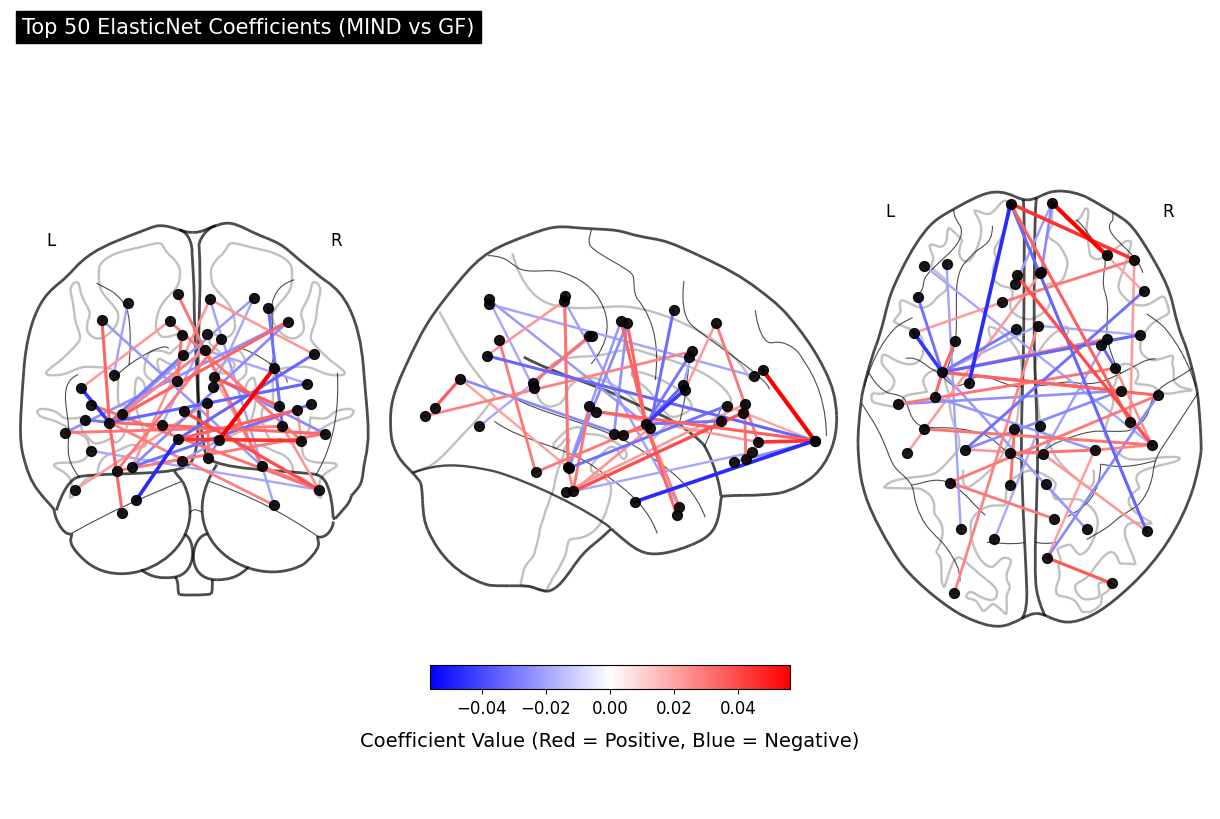

In [3]:
weights_file = '/Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_GF.csv'
plot_elasticnet_weights(weights_file, 'MIND', 'GF', top_n=50)